In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [10]:
import pandas as pd
import numpy as np

In [11]:
date_set_path = "../temp_sets_100/"

## Read Tempdatasets

In [12]:
# read csv file as dataframe, and drop ROW_ID column
def read_csv_no_rowid(file_path):
    df = pd.read_csv(file_path)
    low_list = [x.lower() for x in df.columns]
    df.columns = low_list
    # df.drop(['unnamed: 0', 'row_id'], axis=1, inplace=True)
    df.drop(['row_id'], axis=1, inplace=True)

    return df

In [13]:
# check NaN value

def nan_count(df):
    print("Total columns: " + str(len(df.columns)))
    print("Total rows: " + str(len(df)))
    print("--------------")
    print(df.isnull().sum())

### Chartevents

In [15]:
chartevents_sample_df = read_csv_no_rowid(date_set_path + "chartevents.csv")

In [16]:
# Drop some null value
chartevents_sample_df.dropna(subset=['subject_id', 'hadm_id', 'icustay_id'], inplace=True, axis=0)

In [17]:
chartevents_sample_df.head()

,unnamed: 0,subject_id,hadm_id,icustay_id,itemid,charttime,storetime,cgid,value,valuenum,valueuom,warning,error,resultstatus,stopped
0,0,569,116412,271533.0,644,2105-02-22 15:00:00,2105-02-22 15:13:00,16057,Intact,NaN,NaN,NaN,NaN,NaN,NotStopd
1,1,569,116412,271533.0,550,2105-02-22 15:00:00,2105-02-22 15:13:00,16057,Universal,NaN,NaN,NaN,NaN,NaN,NotStopd
2,2,569,116412,271533.0,581,2105-02-22 15:00:00,2105-02-22 15:13:00,16057,88.5,88.5,kg,NaN,NaN,NaN,NotStopd
3,3,569,116412,271533.0,593,2105-02-22 15:00:00,2105-02-22 15:13:00,16057,Diminished,NaN,NaN,NaN,NaN,NaN,NotStopd
4,4,569,116412,271533.0,599,2105-02-22 15:00:00,2105-02-22 15:13:00,16057,Clear,NaN,NaN,NaN,NaN,NaN,NotStopd


In [18]:
# Drop useless colums
chartevents_sample_df.drop(['storetime', 'cgid', 'valuenum', 'valueuom', 'warning', 'error', 'resultstatus', 'stopped'], axis=1, inplace=True)

In [19]:
nan_count(chartevents_sample_df)

Total columns: 7
Total rows: 674770
--------------
unnamed: 0       0
subject_id       0
hadm_id          0
icustay_id       0
itemid           0
charttime        0
value         3595
dtype: int64


In [20]:
nan_count(chartevents_sample_df)

Total columns: 7
Total rows: 674770
--------------
unnamed: 0       0
subject_id       0
hadm_id          0
icustay_id       0
itemid           0
charttime        0
value         3595
dtype: int64


In [21]:
chartevents_sample_df['value'].fillna(value='Na', inplace=True)

In [22]:
chartevents_sample_df.dtypes

unnamed: 0      int64
subject_id      int64
hadm_id         int64
icustay_id    float64
itemid          int64
charttime      object
value          object
dtype: object

In [23]:
# Transfer some date type
# chartevents_sample_df['subject_id'] = chartevents_sample_df['subject_id'].astype(str)
# chartevents_sample_df['hadm_id'] = chartevents_sample_df['hadm_id'].astype(str)
# chartevents_sample_df['icustay_id'] = chartevents_sample_df['icustay_id'].astype(str)

# chartevents_sample_df['itemid'] = chartevents_sample_df['itemid'].astype(str)

chartevents_sample_df['charttime'] = pd.to_datetime(chartevents_sample_df['charttime'])

In [24]:
chartevents_sample_df.dtypes

unnamed: 0             int64
subject_id             int64
hadm_id                int64
icustay_id           float64
itemid                 int64
charttime     datetime64[ns]
value                 object
dtype: object

In [25]:
len(chartevents_sample_df)

674770

##  Build Network

---

### CTGAN

In [26]:
from sdv.tabular import CTGAN
from sdv.evaluation import evaluate
from sdv.constraints import FixedCombinations

In [27]:
fixed_subject_hadm_icustay_constraint = FixedCombinations(
    column_names=['subject_id', 'hadm_id', 'icustay_id']
)

fixed_item_value_constraint = FixedCombinations(
    column_names=['itemid', 'value']
)

In [28]:
chartevents_constraints = [fixed_subject_hadm_icustay_constraint, fixed_item_value_constraint]

In [29]:
model = CTGAN(constraints=chartevents_constraints, cuda=True, verbose=True, epochs=300)

In [30]:
len(chartevents_sample_df)

674770

In [31]:
train_data = chartevents_sample_df.sample(n=1000)
model.fit(train_data)

Epoch 1, Loss G:  5.6268,Loss D: -0.0010
Epoch 2, Loss G:  5.5939,Loss D: -0.0054
Epoch 3, Loss G:  5.5288,Loss D: -0.0208
Epoch 4, Loss G:  5.6167,Loss D: -0.0248
Epoch 5, Loss G:  5.5414,Loss D: -0.0260
Epoch 6, Loss G:  5.5577,Loss D: -0.0366
Epoch 7, Loss G:  5.6284,Loss D: -0.0354
Epoch 8, Loss G:  5.5546,Loss D: -0.0294
Epoch 9, Loss G:  5.6298,Loss D: -0.0488
Epoch 10, Loss G:  5.4762,Loss D: -0.0380
Epoch 11, Loss G:  5.4846,Loss D: -0.0131
Epoch 12, Loss G:  5.5906,Loss D:  0.0152
Epoch 13, Loss G:  5.3901,Loss D:  0.0170
Epoch 14, Loss G:  5.5003,Loss D: -0.0166
Epoch 15, Loss G:  5.4800,Loss D: -0.0116
Epoch 16, Loss G:  5.4616,Loss D: -0.0503
Epoch 17, Loss G:  5.5434,Loss D: -0.0230
Epoch 18, Loss G:  5.5623,Loss D: -0.0250
Epoch 19, Loss G:  5.3784,Loss D: -0.0036
Epoch 20, Loss G:  5.4395,Loss D: -0.0051
Epoch 21, Loss G:  5.4501,Loss D: -0.0097
Epoch 22, Loss G:  5.3664,Loss D:  0.0099
Epoch 23, Loss G:  5.4929,Loss D: -0.0292
Epoch 24, Loss G:  5.4488,Loss D: -0.0516
E

In [32]:
model.save(date_set_path + "100_models/" + "chartevents_model.pkl")

In [33]:
sample = model.sample(num_rows=1000)

Sampling rows: 100%|██████████| 1000/1000 [00:00<00:00, 13412.80it/s]


In [34]:
chartevents_sample_df['value'] = chartevents_sample_df['value'].astype(str)

In [35]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.7103331114787974

In [36]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

nan

In [37]:
# evaluate(sample, chartevents_sample_df.loc[0:1000, :], aggregate=False)

<AxesSubplot:>

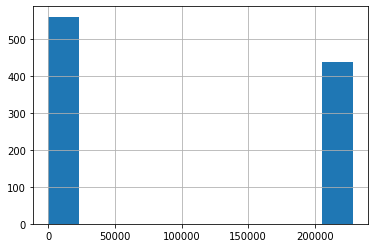

In [38]:
sample.sort_values('itemid')['itemid'].hist()

<AxesSubplot:>

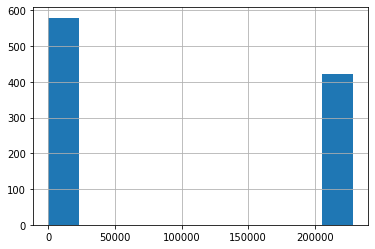

In [39]:
train_data.sort_values('itemid')['itemid'].hist()